In [1]:

import numpy as np 
import pandas as pd

import os
print(os.listdir("../input"))


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold, GridSearchCV
import json
from pandas.io.json import json_normalize
gc.enable()
%matplotlib inline

In [3]:
def convert_json(csv_path='../input/train.csv', nrows=None):
    json_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, converters={column: json.loads for column in json_col}, dtype={'fullVisitorId': 'str'}, nrows=nrows)
    
    for column in json_col:
        col_to_df = json_normalize(df[column])
        col_to_df.columns = [f"{column}.{subcolumn}" for subcolumn in col_to_df.columns]
        df = df.drop(column, axis=1).merge(col_to_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [4]:
%%time
train_df = convert_json()
test_df = convert_json("../input/test.csv")


Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 4min 46s, sys: 18.8 s, total: 5min 5s
Wall time: 5min 5s


**Data Cleaning**

**Drop the columns with non Unique values**

In [6]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

In [7]:
print (train_df.shape)
print (test_df.shape)
train_df.head()

(903653, 36)
(804684, 34)


,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


**Differnece between train and test data**

In [8]:
set(train_df.columns).difference(set(test_df.columns))

{'totals.transactionRevenue', 'trafficSource.campaignCode'}

In [9]:
train_df=train_df.drop(columns='trafficSource.campaignCode')
train_df.shape


(903653, 35)

**Imputing  NAN with 0 and Boolean values**

In [10]:
columns_with_nan = [column for column in train_df.columns if train_df[column].nunique() == 1]
for column in columns_with_nan:
    if set(['not available in demo dataset']) ==  set(train_df[column].unique()): continue
    print(column, train_df[column].dtypes, train_df[column].unique())

totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.isTrueDirect object [nan True]


In [11]:
train_df['totals.bounces'] = train_df['totals.bounces'].fillna('0')
test_df['totals.bounces'] = test_df['totals.bounces'].fillna('0')

train_df['totals.newVisits'] = train_df['totals.newVisits'].fillna('0')
test_df['totals.newVisits'] = test_df['totals.newVisits'].fillna('0')

train_df['trafficSource.adwordsClickInfo.isVideoAd'] = train_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)
test_df['trafficSource.adwordsClickInfo.isVideoAd'] = test_df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)

train_df['trafficSource.isTrueDirect'] = train_df['trafficSource.isTrueDirect'].fillna(False)
test_df['trafficSource.isTrueDirect'] = test_df['trafficSource.isTrueDirect'].fillna(False)

**Adding some features**

In [12]:
trn_len = train_df.shape[0]
mix_df = pd.concat([train_df, test_df])
mix_df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(1708337, 35)

In [13]:
#VisitId and visitStartTime seem to have same values so adding a feature with their differnce makes some sense
mix_df['diff_visitId_time'] = mix_df['visitId'] - mix_df['visitStartTime']
mix_df['diff_visitId_time'] = (mix_df['diff_visitId_time'] != 0).astype(int)
del mix_df['visitId']

In [14]:
#SessionIds are just random numbers hence we can just delete them
del mix_df['sessionId']

In [15]:
#Adding some date features
from datetime import datetime
format = '%Y%m%d' 
mix_df['date_convert'] = mix_df['date'].apply(lambda x: datetime.strptime(str(x), format))
mix_df['month'] = mix_df['date_convert'].apply(lambda x:x.month)
mix_df['quarter_month'] = mix_df['date_convert'].apply(lambda x:x.day//8)
mix_df['day'] = mix_df['date_convert'].apply(lambda x:x.day)
mix_df['weekday'] = mix_df['date_convert'].apply(lambda x:x.weekday())

del mix_df['date']
del mix_df['date_convert']
mix_df.head()

,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitNumber,visitStartTime,diff_visitId_time,month,quarter_month,day,weekday
0,Organic Search,Chrome,desktop,False,Windows,1131660440785968503,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic,NaN,google,1,1472830385,0,9,0,2,4
1,Organic Search,Firefox,desktop,False,Macintosh,377306020877927890,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic,NaN,google,1,1472880147,0,9,0,2,4
2,Organic Search,Chrome,desktop,False,Windows,3895546263509774583,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,(not provided),organic,NaN,google,1,1472865386,0,9,0,2,4
3,Organic Search,UC Browser,desktop,False,Linux,4763447161404445595,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),False,google + online,organic,NaN,google,1,1472881213,0,9,0,2,4
4,Organic Search,Chrome,mobile,True,Android,27294437909732085,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,NaN,NaN,NaN,NaN,True,NaN,NaN,(not set),True,(not provided),organic,NaN,google,2,1472822600,0,9,0,2,4


In [16]:
#Adding mean hits per day
mix_df['totals.hits'] = mix_df['totals.hits'].astype(int)
mix_df['mean_hits_per_day'] = mix_df.groupby(['day'])['totals.hits'].transform('mean')
del  mix_df['day']

In [17]:
mix_df['visitstarttime_convert'] = mix_df['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
mix_df['visitstarttime_convert'] = pd.to_datetime(mix_df['visitstarttime_convert'])
mix_df['visit_hour'] = mix_df['visitstarttime_convert'].apply(lambda x: x.hour)

del mix_df['visitStartTime']
del mix_df['visitstarttime_convert']

In [18]:
train_df = mix_df[:trn_len]
test_df = mix_df[trn_len:]

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903653 entries, 0 to 903652
Data columns (total 37 columns):
channelGrouping                                 903653 non-null object
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
fullVisitorId                                   903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                              903653 non-null object
geoNetwork.metro                                903653 non-null object
geoNetwork.networkDomain                        903653 non-null object
geoNetwork.region                               903653 non-null object
geoNetwork.subContinent                

**2.Visualizations**

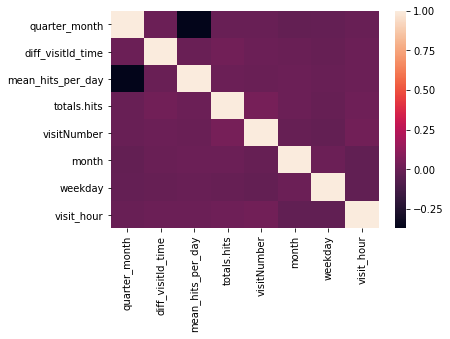

In [64]:
cols =train_df[['quarter_month','diff_visitId_time','mean_hits_per_day','totals.pageviews','totals.hits','totals.bounces','visitNumber','month','weekday','visit_hour']]
cor = cols.corr()
sns.heatmap(cor) 

In [63]:
agg = train_df[['channelGrouping','totals.transactionRevenue']]
temp = agg['channelGrouping'].value_counts()
graph = [go.Pie(labels = temp.index, values = temp.values)]
py.iplot(graph)

In [27]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [33]:
temp = train_df['device.isMobile'].value_counts()
chart = go.Bar(x = ["False","True"], y = temp.values)
py.iplot([chart])

**3 : Clustering Visualization**

In [61]:
def plot_agg(col,color1,color2):
    col_count = train_df[col].value_counts()
    col_chart = go.Bar(x = col_count.head(10).index, y = col_count.head(10).values, name="Count",marker = dict(color=color1))

    col_mean = train_df[[col,'totals.transactionRevenue']][(train_df['totals.transactionRevenue'] >1)]
    col_mean = col_mean.groupby(col)['totals.transactionRevenue'].mean().sort_values(ascending=False)
    col_mean_graph = go.Bar(x = col_mean.head(10).index, y = col_mean.head(10).values, name="Mean",marker = dict(color=color2))

    fig = tools.make_subplots(rows = 1, cols = 2,subplot_titles=('Total Count','Mean Revenue'))
    fig.append_trace(col_chart, 1,1)
    fig.append_trace(col_mean_graph,1,2)
    py.iplot(fig)
plot_agg('device.browser',"#7F1BFB","#FD9970")


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [59]:
plot_agg('geoNetwork.continent',"#F481F1","#F9985B")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [65]:
trn_len = train_df.shape[0]
mix_df = pd.concat([train_df, test_df])
mix_df.shape

(1708337, 37)

**Using Label Encoding to convert categorial features into numerical values**

In [66]:
for col in mix_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour', 'WoY']: continue
    if mix_df[col].dtypes == object or mix_df[col].dtypes == bool:
        mix_df[col], indexer = pd.factorize(mix_df[col])

In [67]:
non_categorial = [col for col in mix_df.columns if 'totals.' in col]
non_categorial += ['visitNumber', 'mean_hits_per_day', 'fullVisitorId']
categorical_feats =  [col for col in mix_df.columns if col not in non_categorial]

In [68]:
for col in categorical_feats:
    mix_df[col] = mix_df[col].astype(int)

In [69]:
train_df = mix_df[:trn_len]
test_df = mix_df[trn_len:]

In [72]:
del test_df['totals.transactionRevenue']


In [74]:
target = train_df['totals.transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log1p(x))
del train_df['totals.transactionRevenue']

**4. Predict Buying Probabilities**

In [76]:
y_out=np.where(target>0,1,0)
y_out

array([0, 0, 0, ..., 0, 0, 0])

In [80]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
mod=lr.fit(train_df,y_out)
pred=mod.predict_proba(test_df)
pred=pred[:,1]
by_visitor=pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"]})
by_visitor["prob"]=pred
by_visitor=by_visitor.groupby("fullVisitorId")["prob"].sum().reset_index()
by_visitor=by_visitor.sort_values(['prob'],ascending=False)

In [82]:
top_ten=by_visitor['fullVisitorId'][0:10]
top_ten

21480     0348420048060754000
284290     460252456180441002
37026     0603203541488487946
436043     705991343467703841
50876     0827807801897731454
372900     603935369785924594
114206     185123961166899959
34370     0559117980865655686
76375      123908736868363882
296982     480773587297538354
Name: fullVisitorId, dtype: object

**5.**

**Predict : LGBM**

In [ ]:
#reference : LGBM starter code

param={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }


In [ ]:
# for permutation test

#trn_cols = [col for col in train_df.columns if col not in ['fullVisitorId',totals.pageviews]]
#trn_cols = [col for col in train_df.columns if col not in ['fullVisitorId',totals.hits]]
#trn_cols = [col for col in train_df.columns if col not in ['fullVisitorId',totals.bounces]]
#trn_cols = [col for col in train_df.columns if col not in ['fullVisitorId',trafficSource.adContent]]



In [ ]:
trn_cols = [col for col in train_df.columns if col not in ['fullVisitorId']]

In [ ]:
from sklearn.model_selection import KFold
folds = KFold(n_splits=5, shuffle=True, random_state=15)
out = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

features = list(train_df[trn_cols].columns)
imp_features = pd.DataFrame()

for fold_, (train_id, val_id) in enumerate(folds.split(train_df.values, target.values)):
    trn_data = lgb.Dataset(train_df.iloc[train_id][trn_cols], label=target.iloc[train_id], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_id][trn_cols], label=target.iloc[val_id], categorical_feature=categorical_feats)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    out[val_id] = clf.predict(train_df.iloc[val_id][trn_cols], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    imp_features = pd.concat([imp_features, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[trn_cols], num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
print("CV score: {:<8.5f}".format(mean_squared_error(out, target)**0.5))

In [ ]:
final = test_df[['fullVisitorId']].copy()
final.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)
by_visitor_test = final[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
by_visitor_test["PredictedLogRevenue"] = np.log1p(by_visitor_test["PredictedLogRevenue"])
by_visitor_test.to_csv('submit.csv',index=False)

> **Using XGBoost : **
**user level prediction**

In [ ]:
#reference :Teach_LightGBM_to_Sum_Predictions
train_df['predictions'] = np.expm1(oof)
test_df['predictions'] = predictions

In [ ]:
trn_data = train_df[features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [ ]:
%%time

trn_pred_list = train_df[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [ ]:

trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
trn_all_predictions.to_csv('trn_all_predictions.csv', index=False)
full_data = pd.concat([trn_data, trn_all_predictions], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

In [ ]:
%%time
sub_pred_list = test_df[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})

In [ ]:
gc.collect()

In [ ]:
sub_data = test_df[features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)
sub_full_data = pd.concat([sub_data, sub_all_predictions], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

In [ ]:
train_df['target'] = np.expm1(target)
trn_user_target = train_df[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [ ]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.02,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }
params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }


In [ ]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # 
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # 
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [ ]:
from xgboost import XGBRegressor
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xg = XGBRegressor(**xgb_params, n_estimators=1000)
    
    reg = lgb.LGBMRegressor(**params,

        n_estimators=1500,

    )
    
    xg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    
    pre = xg.predict(sub_full_data[full_data.columns])
    pre[pre<0]=0
    
    sub_preds += (_preds / len(folds)) * 0.6 + (pre / len(folds)) * 0.4
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

In [ ]:
submission = test_df[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test.to_csv('submit.csv',index=False)